# Analyse Event of G-ring Data

An earthquake in 2024 is analysed using the G-ring laser rotation data for the vertical component (thus only for Love waves), from a local MSEED file.

In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees import sixdegrees

from plots.plot_backazimuth_results import plot_backazimuth_results
from plots.plot_velocities import plot_velocities
from plots.plot_waveform_cc import plot_waveform_cc
from plots.plot_cwt_all import plot_cwt_all

## Configurations

In [26]:
config = {
    # Required time window parameters
    'tbeg': "2024-12-05 18:44:21",  # Start time
    'tend': "2024-12-05 20:44:21",  # End time

    # event
    'origin_time': "2024-12-05 18:44:26",
    'magnitude': 7.0,

    # station coordinates
    'station_lat': 49.1448,
    'station_lon': 12.8803,

    # SEED identifiers
    'seed': "XX.RLAS..",     # seed ID of output stream
    'rot_seed': ["XX.RLAS..BJZ"], # Rotation sensor seed ID
    'tra_seed': ["XX.RLAS..BHZ", "XX.RLAS..BHN", "XX.RLAS..BHE"],  # Translation sensor seed ID
    
    # rotate to ZNE
    'rotate_to_zne': False,

    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/G_eventM7.0.mseed",

    # Remove responses
    'tra_remove_response': True,
    'rot_remove_response': True,

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "G_Analysis",  # Project name
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Alternatively load configuration from yaml file

In [27]:
# config = sixdegrees.load_from_yaml("config/config_G_M7.0_20241205.yml")

Setup a sixdegrees object

In [28]:
sd = sixdegrees(conf=config)

INFO: no path to translation station inventory given!
INFO: no path to rotation station inventory given!


Store the configuration as a pickle file

In [29]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [30]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.RLAS..BHZ data from mseed file
-> fetching XX.RLAS..BHN data from mseed file
-> fetching XX.RLAS..BHE data from mseed file
3 Trace(s) in Stream:
XX.RLAS..BHZ | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
XX.RLAS..BHN | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
XX.RLAS..BHE | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
-> fetching XX.RLAS..BJZ data from mseed file
1 Trace(s) in Stream:
XX.RLAS..BJZ | 2024-12-05T18:44:19.981749Z - 2024-12-05T20:44:21.981749Z | 20.0 Hz, 144041 samples


Get key information about the earthquake

In [31]:
try:
    ev = sd.get_event_info(
        origin_time=config['origin_time'],
        base_catalog="USGS",
        magnitude=config['magnitude']
    )
except:
    print("No event found")


Found event:
Origin time: 2024-12-05T18:44:21.110000Z
Magnitude: 7.0 mw
Location: 40.374°N, -125.022°E
Depth: 10.0 km
Epicentral Distance: 9264.5 km
Epicentral Distance: 83.3°
Backazimuth: 329.1°


Ensure that all traces of stream have the same sample size

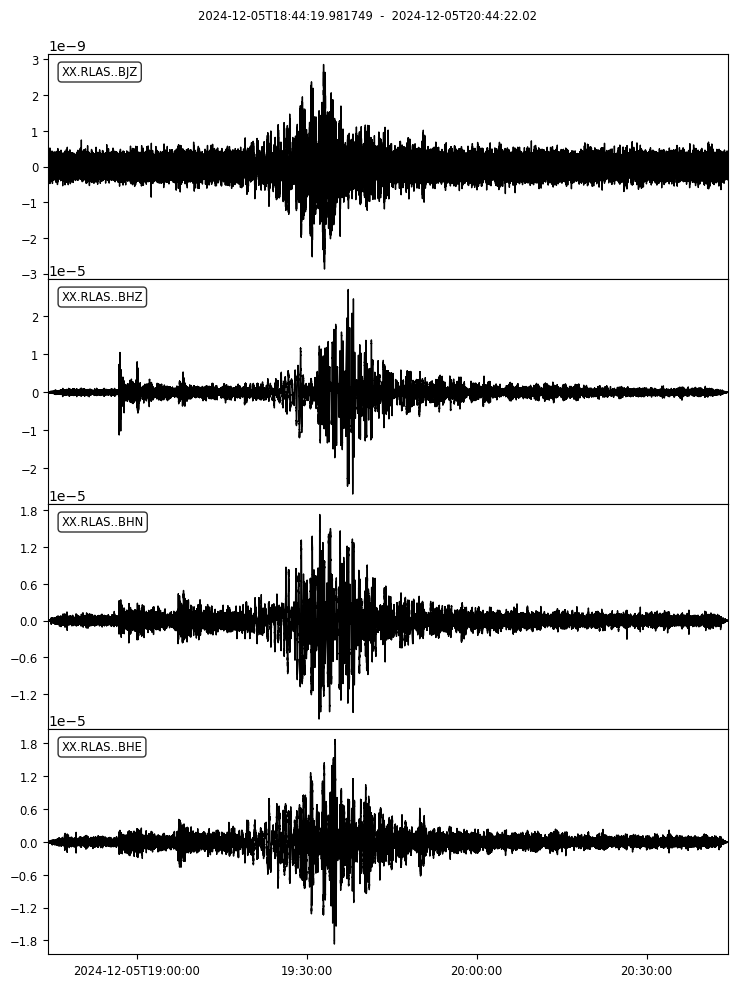

In [32]:
sd.st.plot(equal_scale=False);

In [33]:
sd.trim_stream(set_common=True, set_interpolate=False)

## Analysis

### Wavelet Comparsion

In [35]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        component = rot_data.stats.channel
        cwt_results[f"{component}"] = sd.compute_cwt(
            rot_data.times(), rot_data.data, rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        component = acc_data.stats.channel
        cwt_results[f"{component}"] = sd.compute_cwt(
            acc_data.times(), acc_data.data, acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


No N data for rotation
No E data for rotation


In [36]:
# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation").copy(),
    acc=sd.get_stream("translation").copy(),
    cwt_output=cwt_results,
    clog=True,
    ylim=1
)

del fig

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [ ]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [ ]:
sd.polarity_stream(pol_dict={"HZ": 1, "JZ": 1}, raw=True)

Let's cut to the main event

In [ ]:
sd.st.trim(starttime=UTCDateTime(config['tbeg']) + 500, endtime=UTCDateTime(config['tend']) - 2000)

4 Trace(s) in Stream:
XX.RLAS..BHZ | 2024-12-05T18:52:41.020000Z - 2024-12-05T20:11:01.020000Z | 20.0 Hz, 94001 samples
XX.RLAS..BHN | 2024-12-05T18:52:41.020000Z - 2024-12-05T20:11:01.020000Z | 20.0 Hz, 94001 samples
XX.RLAS..BHE | 2024-12-05T18:52:41.020000Z - 2024-12-05T20:11:01.020000Z | 20.0 Hz, 94001 samples
XX.RLAS..BJZ | 2024-12-05T18:52:41.031749Z - 2024-12-05T20:11:01.031749Z | 20.0 Hz, 94001 samples

Let's compare the waveforms of the rotation (red) and translational (black) components based on the cross-correlation in time windows

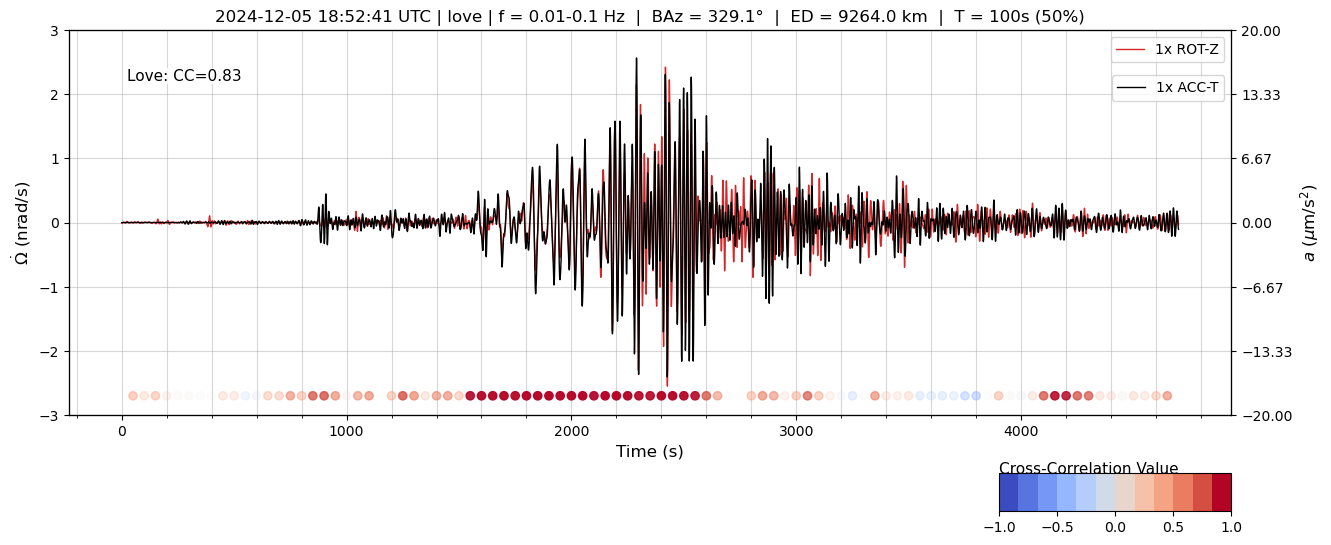

In [ ]:
fig = plot_waveform_cc(
    rot0=sd.get_stream("rotation").copy(),
    acc0=sd.get_stream("translation").copy(),
    baz=ev['backazimuth'],
    distance=ev['distance_km'],
    fmin=sd.fmin, 
    fmax=sd.fmax, 
    twin_sec=100, 
    twin_overlap=0.5,
    wave_type='love'
)

### Backazimuth Estimate

In [37]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)


Plot the results of the backazimuth estimation using the midpoint approach

baz_max = 315, baz_std = 33


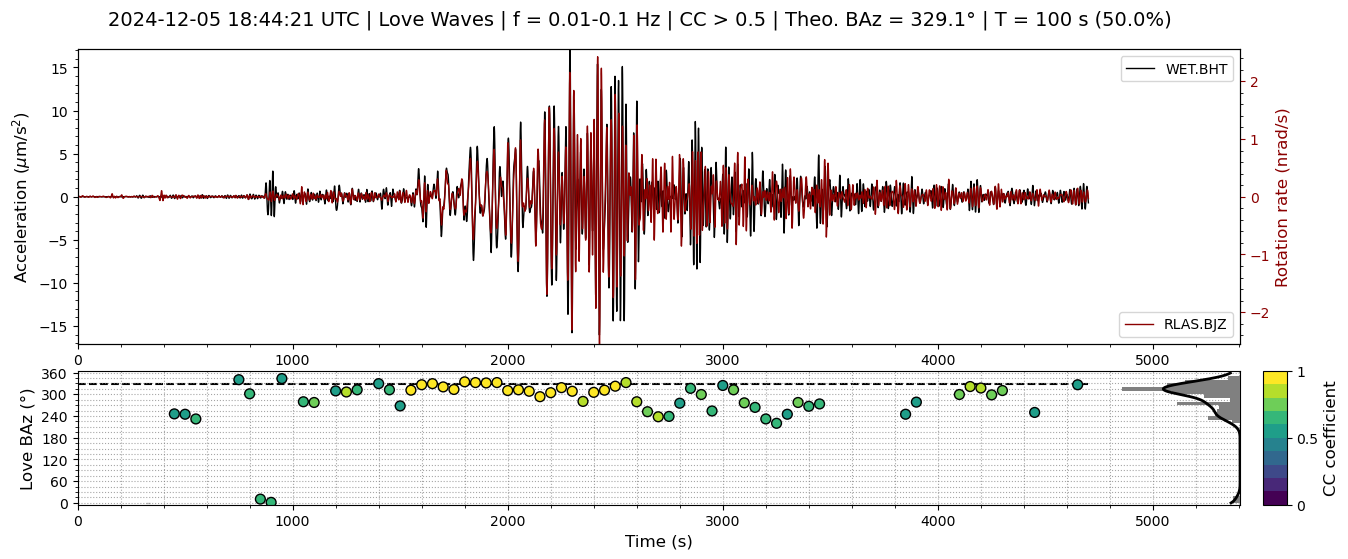

In [ ]:

fig = plot_backazimuth_results(
    sd, 
    baz_results,
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,
    cc_method='mid'
)

Plot the results of the backazimuth estimation using the maximum CC approach

baz_max = 310, baz_std = 24


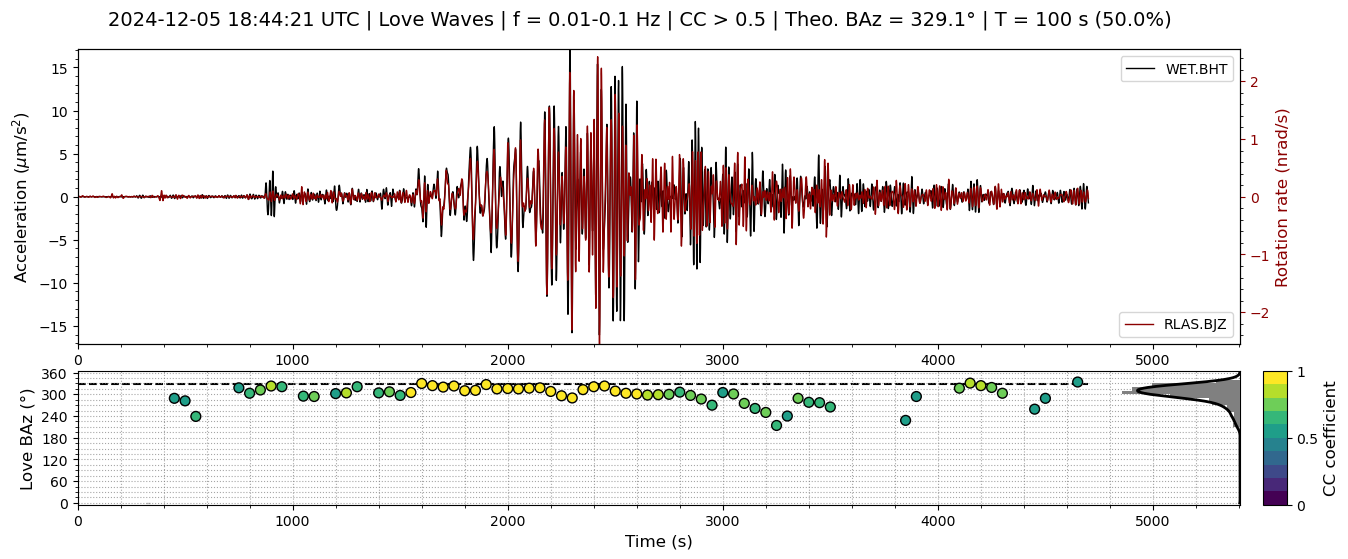

In [ ]:

fig = plot_backazimuth_results(
    sd, 
    baz_results,
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,
    cc_method='max'
)

### Analyse phase velocities

In [ ]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=50.0,
    overlap=0.5,
    cc_threshold=0.,
    method='odr',
    baz=ev['backazimuth']  # optional
)


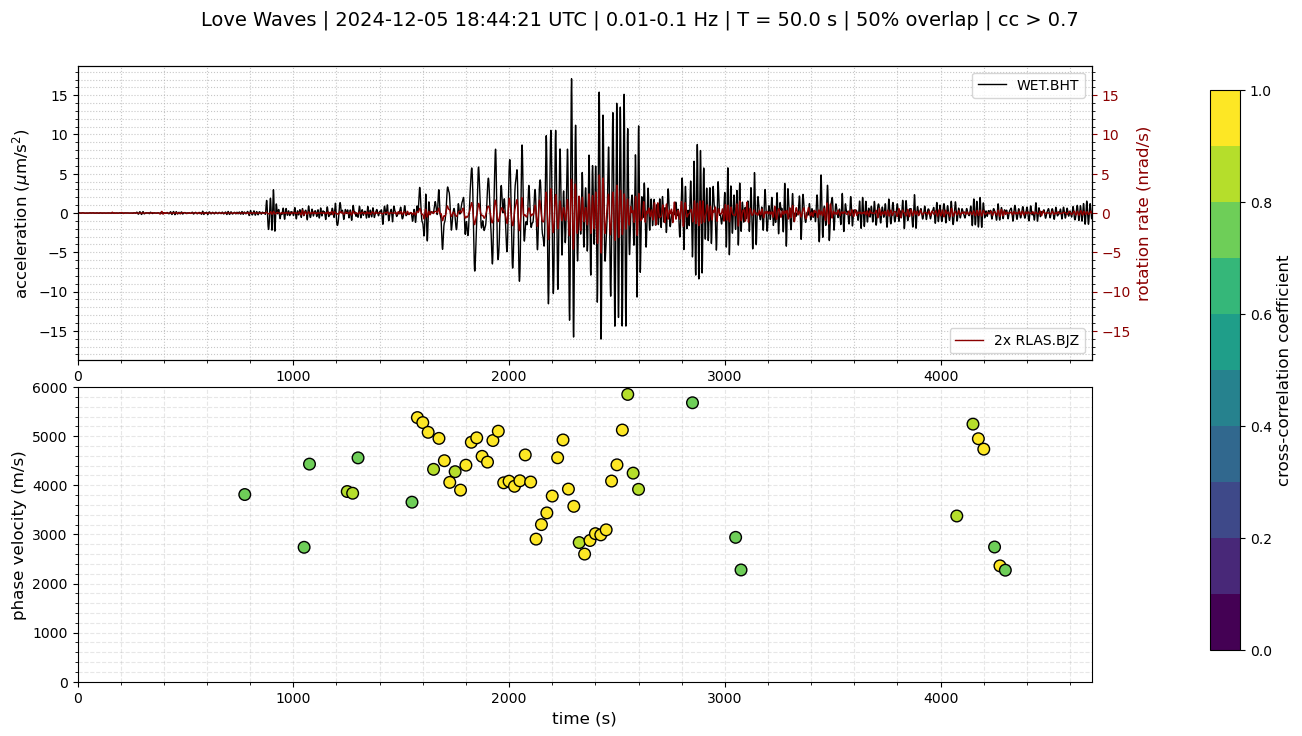

In [ ]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=6000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)


In [ ]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=50.0,
    overlap=0.5,
    cc_threshold=0.,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

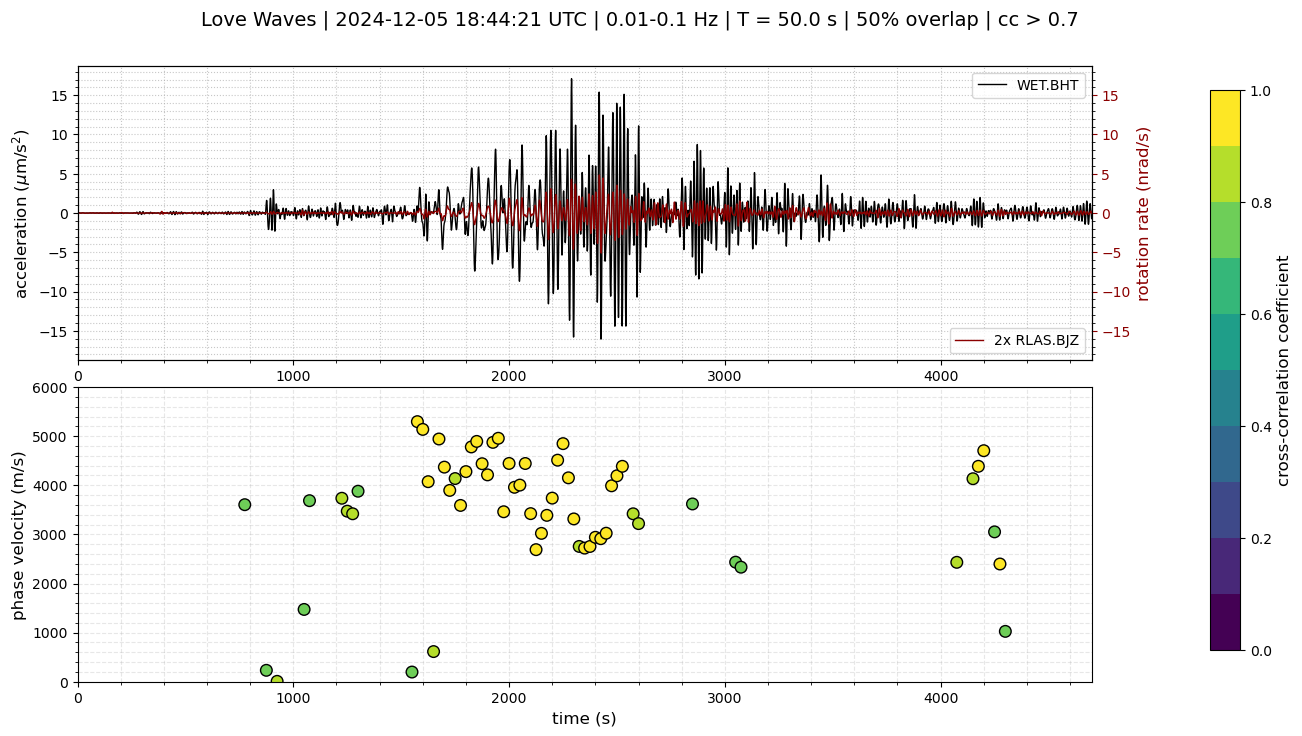

In [ ]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=6000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)
